In [24]:
%pylab inline
import os
import gc
import scipy
import smatch
import healpy as hp
import numpy as np
import catutil as utilities
import imgSimutil as hscimgUtil
import astropy.table as astTable
import numpy.lib.recfunctions as rfn

Populating the interactive namespace from numpy and matplotlib


## First, Divide into three catalogs

In [2]:
import galsim
import fitsio
import healpy as hp

nside=512
hpInfo=fitsio.read(hscimgUtil.hpInfofname %nside)
cosmo252=hscimgUtil.cosmoHSTGal('252')
cosmo252.readHSTsample()
cat=cosmo252.catused

In [3]:
bds=np.linspace(17,28,15)
bdc=(bds[1:]+bds[:-1])/2.
nums,bds=np.histogram(cat['mag_auto'],bins=bds,density=False)

In [4]:
fname=os.path.join(os.environ['homeWrk'],'COSMOS/cosmos_leauthaud_2007/COSMOS_ACS_catalog/acs_clean_only.fits')
data=astTable.Table.read(fname)
data=data[(data['MU_CLASS']==1)&(data['NEARSTAR']==1)&data['MASKED']==1]
nums2,bds2=np.histogram(data['MAG_AUTO'],bins=bds,density=False)

Text(0, 0.5, 'log(N)')

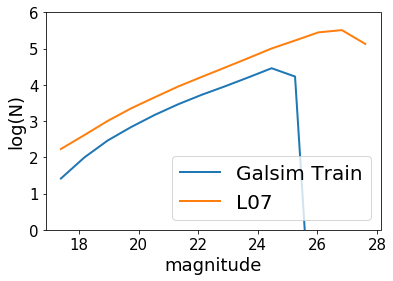

In [5]:
plt.plot(bdc,np.log10(nums+0.000001),label='Galsim Train')
plt.plot(bdc,np.log10(nums2+0.00001),label='L07')
plt.legend()
plt.ylim(0,6)
plt.xlabel('magnitude')
plt.ylabel('log(N)')

In [6]:
zname=os.path.join(os.environ['homeWrk'],'COSMOS/cosmos_laigle2015/COSMOS2015_Laigle+_v1.1.fits')
zata=astTable.Table.read(zname)
msk=(zata['PHOTOZ']>1e-5)&(zata['PHOTOZ']<5.4)
zata=zata[msk]

In [7]:
nside=4096 # healpix nside
maxmatch=1 # return closest match

# ra,dec,radius in degrees
matches = smatch.match(cat['ra'],cat['dec'], 0.3/3600.,
                       data['ALPHA_J2000'],data['DELTA_J2000'],
                       nside=nside, maxmatch=maxmatch)
data['TRAIN_IND']=-99
data['TRAIN_IND'][matches['i2']]=cat['index'][matches['i1']]
data['L2015_num']=-99

In [8]:
matched=data[data['TRAIN_IND']>-1]
unmatched=data[data['TRAIN_IND']<-1]

In [9]:
# ra,dec,radius in degrees
matches = smatch.match(zata['ALPHA_J2000'],zata['DELTA_J2000'], 0.5/3600.,
                       unmatched['ALPHA_J2000'],unmatched['DELTA_J2000'],
                       nside=nside, maxmatch=maxmatch)
final=unmatched[matches['i2']]
final['zphot']=zata[matches['i1']]['PHOTOZ']
final['L2015_num']=zata[matches['i1']]['NUMBER']

In [10]:
sel=np.ones(len(unmatched),dtype=bool)
sel[matches['i2']]=False
unmatchedF=unmatched[sel]

In [11]:
print((len(final)+len(matched))/1.65/3600.)
print(len(unmatchedF)/1.65/3600.)

77.13383838383838
113.50791245791247


In [12]:
oname1=os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_extended','L07xG3train252.fits')
matched.write(oname1,overwrite=True)

In [13]:
oname3=os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_extended','L07_left.fits')
unmatchedF.write(oname3,overwrite=True)

## Then, match L07x15z to the traning sample by radius

In [14]:
e1M=(matched['CXX_IMAGE']-matched['CYY_IMAGE'])/(matched['CXX_IMAGE']+matched['CYY_IMAGE'])
e2M=2*matched['CXY_IMAGE']/(matched['CXX_IMAGE']+matched['CYY_IMAGE'])
absEM=np.sqrt(e1M**2.+e2M**2.)
xyRef=np.vstack([absEM,matched['FWHM_IMAGE']/25]).T

e1=(final['CXX_IMAGE']-final['CYY_IMAGE'])/(final['CXX_IMAGE']+final['CYY_IMAGE'])
e2=2*final['CXY_IMAGE']/(final['CXX_IMAGE']+final['CYY_IMAGE'])
absE=np.sqrt(e1**2.+e2**2.)
xyDat   =   np.vstack([absE,final['FWHM_IMAGE']/25]).T

#plt.hist(absE,bins=50)
#plt.hist(final['FWHM_IMAGE']/25,bins=50,range=(0,2))

In [15]:
tree    =   scipy.spatial.cKDTree(xyRef)
dis,inds=tree.query(xyDat,k=1)
final['TRAIN_IND']=matched['TRAIN_IND'][inds]

oname2=os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_extended','L07xL15z.fits')
final.write(oname2,overwrite=True)

## Healpix 

In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [17]:
from pixel3D import cartesianGrid3D
from configparser import ConfigParser
names=['ALPHA_J2000','DELTA_J2000','MAG_AUTO','TRAIN_IND','zphot']

oname2=os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_extended','L07xL15z.fits')
final=astTable.Table.read(oname2)[names]
final.rename_column('ALPHA_J2000','ra')
final.rename_column('DELTA_J2000','dec')
final.rename_column('TRAIN_IND','index')
final.rename_column('MAG_AUTO','mag_auto')

In [20]:
nside=512
hpInfo=pyfits.getdata(hscimgUtil.hpInfofname %nside)

parser  =   ConfigParser()
configName='config-pix-nl1.ini'
parser.read(configName)
gridInfo=   cartesianGrid3D(parser)
# prepare healPIX inds
for pixId in hscimgUtil.cosmoHSThpix:
    # setup projected plane
    dd =  hpInfo[hpInfo['pix']==pixId]
    nx =  int(dd['dra']/gridInfo.delta)
    ny =  int(dd['ddec']/gridInfo.delta)
    gridInfo.setupNaivePlane(nx,ny,dd['raMin'],dd['decMin'])
    mask  =   (final['ra']>dd['raMin'])\
            &(final['ra']<dd['raMax'])\
            &(final['dec']>dd['decMin'])\
            &(final['dec']<dd['decMax'])
    out   =   final[mask]
    del mask
    x,y=  gridInfo.project_tan(out['ra'],out['dec'],pix=True)
    xI =  np.int_(x+0.5)
    yI =  np.int_(y+0.5)
    np.random.seed(pixId)
    dx =  np.random.rand(len(x))-0.5
    dy =  np.random.rand(len(y))-0.5
    out['xI']=xI
    out['yI']=yI
    out['dx']=dx
    out['dy']=dy
    ofname  =   os.path.join(os.environ['homeWrk'],\
             'COSMOS/galsim_train/COSMOS_25.2_extended/healpix-nside512','cat-%d-25.2.fits' %pixId)
    out.write(ofname,overwrite=True)
    del out
    gc.collect()

In [3]:
for pixId in hscimgUtil.cosmoHSThpix:
    ofname  =   os.path.join(os.environ['homeWrk'],\
             'COSMOS/galsim_train/COSMOS_25.2_extended/healpix-nside512','cat-%d-25.2.fits' %pixId)
    aa=pyfits.getdata(ofname)
    if len(aa)<5:
        print(pixId)
        os.popen('rm ofname')
    del aa
    gc.collect()

1744591
1744611


In [3]:
# Stack with the 252 catalog

In [54]:
pix_scale=  0.168/3600.
pixId=1743742
cosmo252 =  hscimgUtil.cosmoHSTGal('252')
cosmo252E=  hscimgUtil.cosmoHSTGal('252E')

info    =   cosmo252.hpInfo[cosmo252.hpInfo['pix']==pixId]
nx      =   int(info['dra']/pix_scale)
ny      =   int(info['ddec']/pix_scale)

cat_tmp1=   cosmo252.readHpixSample(pixId)
cat_tmp2=   cosmo252E.readHpixSample(pixId)
hstcat  =   rfn.stack_arrays([cat_tmp1,cat_tmp2],usemask=False,autoconvert=True)

In [55]:
print(hstcat['xI'].max())
print(hstcat['xI'].max()-hstcat['xI'].min())
print(hstcat['yI'].max()-hstcat['yI'].min())
area=(hstcat['yI'].max()-hstcat['yI'].min())*(hstcat['xI'].max()-hstcat['xI'].min())*(0.168/60.)**2.
print(area)
print(len(hstcat)/area)

4623
4622
3515
127.37122719999999
56.786765417927924


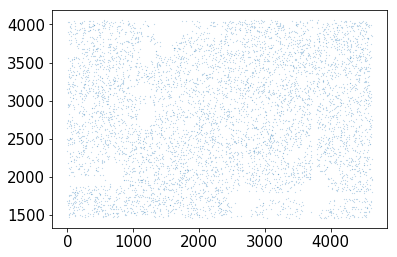

In [56]:
plt.scatter(cat_tmp2['xI'],cat_tmp2['yI'],s=0.01)

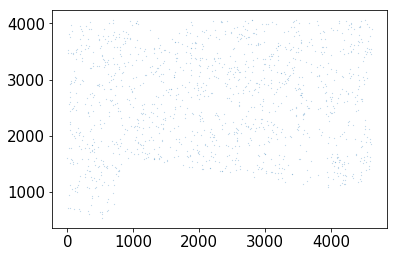

In [57]:
plt.scatter(cat_tmp1['xI'],cat_tmp1['yI'],s=0.01)

(array([156., 384., 389., 147.,  88.,  72.,  64.,  20.,   8.,   6.]),
 array([0.0239    , 0.45175001, 0.87960002, 1.30745003, 1.73530005,
        2.16315006, 2.59100007, 3.01885008, 3.44670009, 3.8745501 ,
        4.30240011]),
 <a list of 10 Patch objects>)

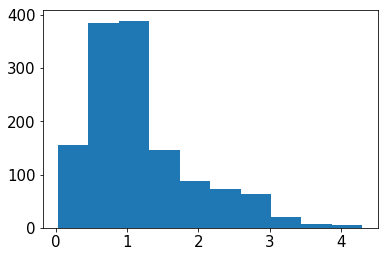

In [20]:
plt.hist(cat_tmp1['zphot'])

(array([1068., 1867., 1270., 1053.,  698.,  438.,  300.,  152.,   73.,
          43.]),
 array([5.1000002e-03, 5.4170001e-01, 1.0783000e+00, 1.6149000e+00,
        2.1515000e+00, 2.6880999e+00, 3.2247000e+00, 3.7612998e+00,
        4.2978997e+00, 4.8344998e+00, 5.3710999e+00], dtype=float32),
 <a list of 10 Patch objects>)

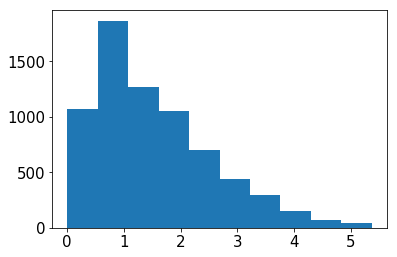

In [21]:
plt.hist(cat_tmp2['zphot'])